<a href="https://colab.research.google.com/github/Mehrnoushhk/DeepLearning/blob/master/PinAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Pin Bar Trading Artificial Intelligence Model
### Steps: <br>
1.   Read and preprocess data
2.   Define and find PinBars 
3.   Define the trend after pinbars
4.   Prepare the dataset
5.   Create machine learning model
6.   Train the model 



In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Reading data
url= 'https://raw.githubusercontent.com/Mehrnoushhk/DeepLearning/master/USDJPYm30.csv'
data= pd.read_csv(url) 
data.columns= ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'] 
data.head(n= 5)

,Date,Time,Open,High,Low,Close,Volume
0,2018.02.14,20:00,107.051,107.095,106.792,106.820,5968
1,2018.02.14,20:30,106.820,107.002,106.819,106.988,4931
2,2018.02.14,21:00,106.989,107.066,106.949,106.958,4229
3,2018.02.14,21:30,106.959,107.126,106.903,107.076,5510
4,2018.02.14,22:00,107.075,107.168,107.032,107.039,4537


In [ ]:
# Converting Time and Date to proper DateTime format
%%time
import datetime
for i in range(0, data.shape[0]):
  temptext= data.iloc[i, 0]
  a= int(temptext[0:4])
  b= int(temptext[5:7])
  c= int(temptext[8:])
  temptime= data.iloc[i, 1]
  h= int(temptime[:-3])
  tempdate= datetime.datetime(year= a, month= b, day= c, hour= h, minute= 0, second= 0)
  data.iloc[i,0]= tempdate

CPU times: user 20.6 s, sys: 27 ms, total: 20.6 s
Wall time: 20.5 s


In [ ]:
del data['Time']
data.set_index('Date', inplace= True)
data.index= pd.to_datetime(data.index)

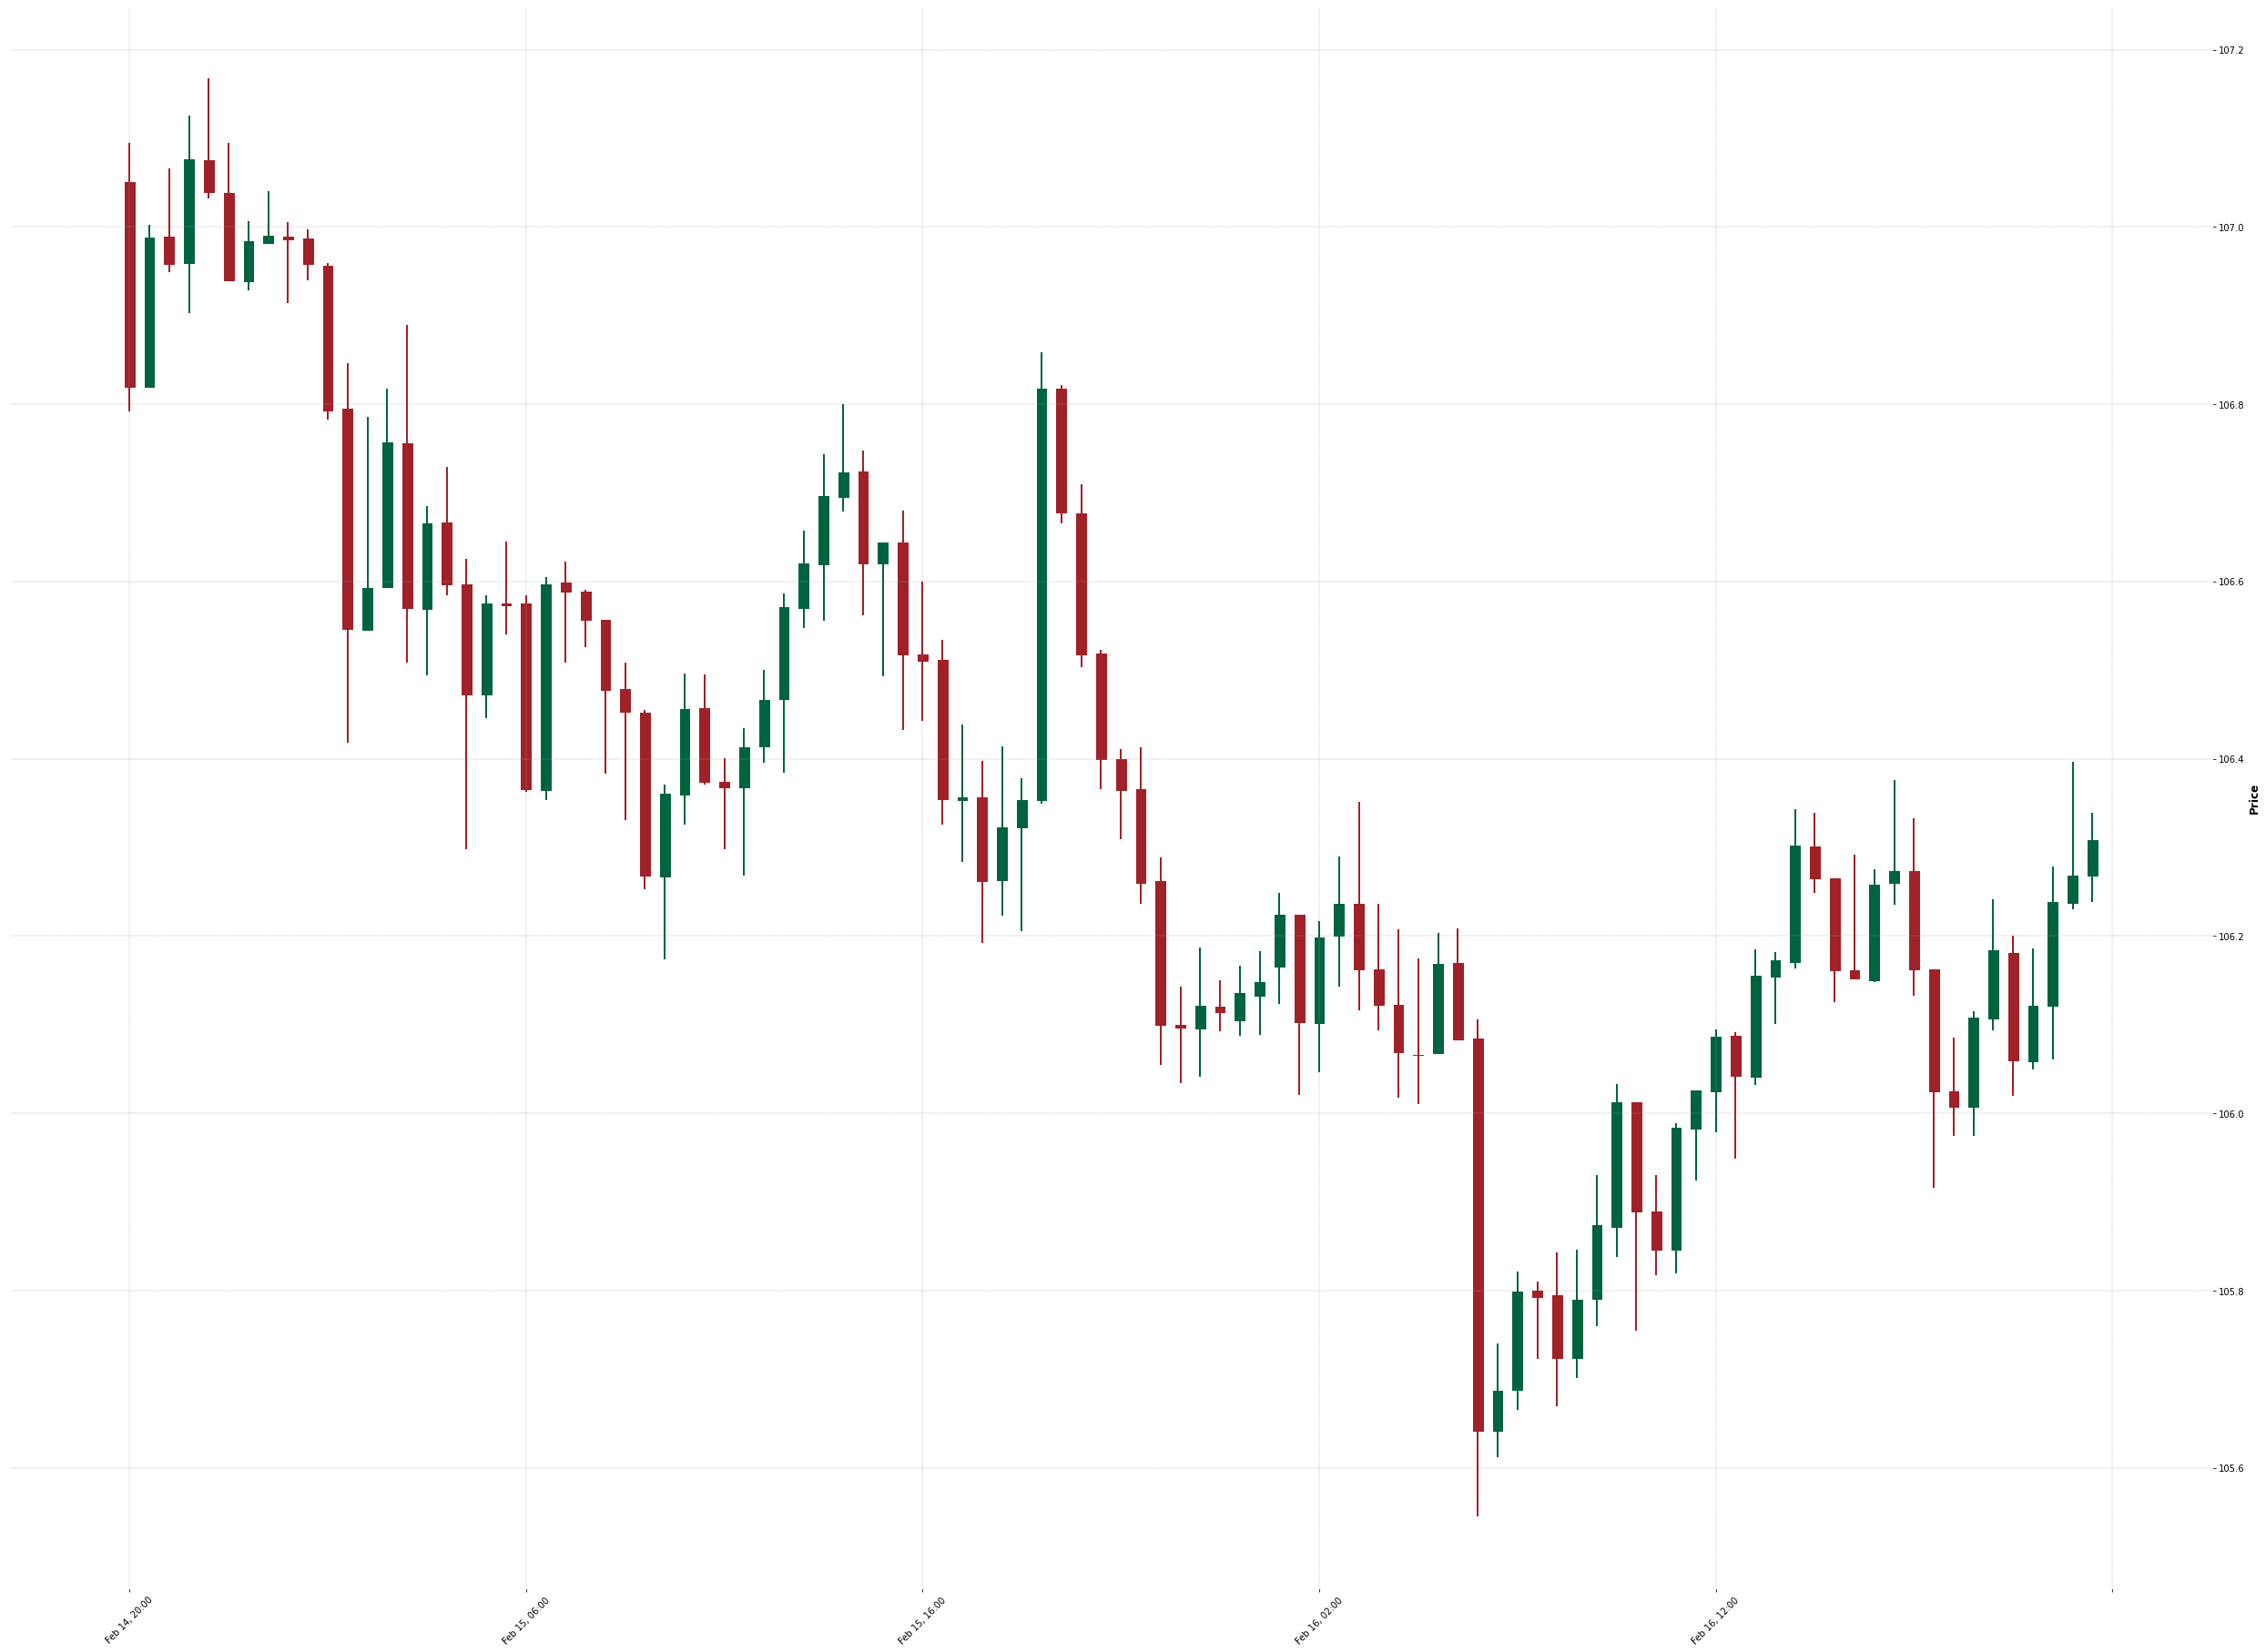

In [ ]:
!pip install mplfinance
import mplfinance as mpl
mpl.plot(data.iloc[0:100,:], type= 'candle', style= 'charles', figscale= 6) # , savefig= '/content/Plots/fig01.png'

In [ ]:
# Function to search for Pinbar


In [ ]:
# Function to see what happens after 




In [ ]:
# Create LSTM model




In [ ]:
# Feed data to model

